In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
%matplotlib inline

<font size="5">Making a custom power spectrum</font>


Text(0, 0.5, '$D_l$')

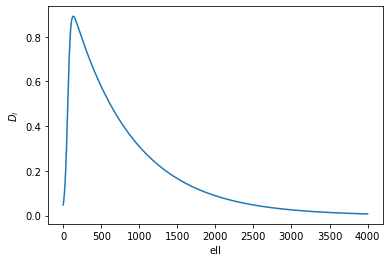

In [2]:
lmax=4000
ell=np.arange(0,lmax+1)

dl=1/(np.exp((60-ell)/20)+np.exp((ell-60)/800))

plt.plot(ell,dl)
plt.xlabel("ell")
plt.ylabel("$D_l$")

Text(0, 0.5, '$ln(D_l)$')

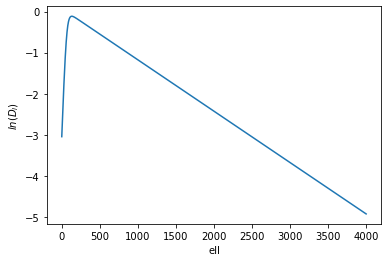

In [3]:
plt.plot(ell,np.log(dl))
plt.xlabel("ell")
plt.ylabel("$ln(D_l)$")

<ipython-input-4-9007cb9dfb48>:1: RuntimeWarning: divide by zero encountered in true_divide
  ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)


array([5.40000000e+00, 5.40135034e+00, 5.40270135e+00, ...,
       1.08000000e+04, 2.16000000e+04,            inf])

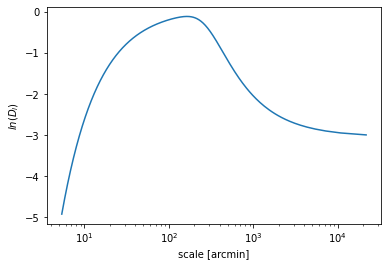

In [4]:
ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)
ellsc=ellsc[::-1]

fdl=dl[::-1]

plt.plot(ellsc,np.log(fdl))
plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')
ellsc

In [5]:
cl = dl * 2 * np.pi / (ell*(ell+1.))
cl[0]=0
cl[1]=0

<ipython-input-5-61d338a088c4>:1: RuntimeWarning: divide by zero encountered in true_divide
  cl = dl * 2 * np.pi / (ell*(ell+1.))


In [6]:
lmax

4000

<font size="5">Making a full sky map</font>


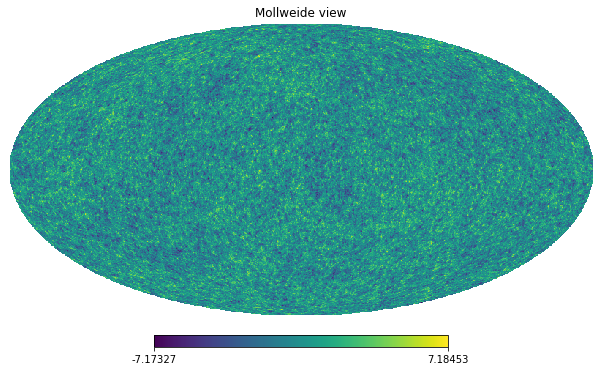

In [7]:
seed = 589
np.random.seed(seed)

alm = hp.synalm((cl), lmax=lmax, new=True)
nside=1024

hmap=hp.alm2map(alm, nside=nside, lmax=lmax)

hp.mollview(hmap)

Calculating the power spectrum from the map

In [8]:
rcl=hp.anafast(hmap,lmax=lmax,use_pixel_weights=True)

rdl=ell * (ell + 1.) * rcl/(np.pi*2)

Text(0, 0.5, '$\\frac{\\ell(\\ell+1)}{2\\pi}C_{\\ell}$')

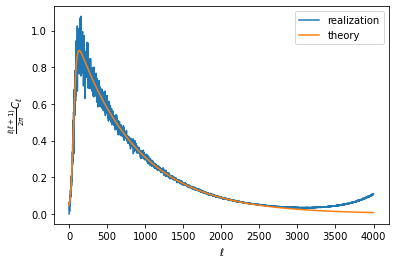

In [9]:
plt.plot(ell,rdl ,label='realization')
plt.plot(ell,dl,label='theory')
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel(r"$\frac{\ell(\ell+1)}{2\pi}C_{\ell}$")

<ipython-input-10-3be87fbfde33>:1: RuntimeWarning: divide by zero encountered in true_divide
  ellsc=21600/ell


Text(0, 0.5, '$ln(D_l)$')

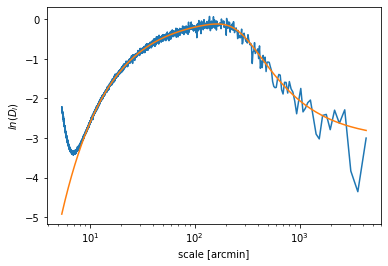

In [10]:
ellsc=21600/ell
ellsc=ellsc[::-1]

fdl=rdl[::-1]
tfdl=dl[::-1]

plt.plot(ellsc[:-5],np.log(fdl[:-5]),label='realization')
plt.plot(ellsc[:-5],np.log(tfdl[:-5]),label='theory')

plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')

resolution of the map

In [11]:
nside=hp.npix2nside(len(hmap))
resarc=hp.nside2resol(nside,arcmin=True)
resol=hp.nside2resol(nside)
print("resolution = %.2f arcmin" % resarc)

resolution = 3.44 arcmin


Fourier transform of the morlet wavelet in real space (1D)

In [30]:
def morletfft(sigma,freq,T):
    t=np.arange(0,T)
    gabor=np.exp(-(t**2)/(2*sigma**2))*np.exp(1.j*freq*t)
    #beta=np.exp(-((freq**2) *sigma**2)/2)
    #beta = np.sum (gabor)/ np.sum (np.exp(-(t**2)/(2*sigma**2)))
    lowp=np.exp(-(t**2)/(2*sigma**2))
    norm=np.sqrt(2*np.pi*sigma**2)
    beta = np.sum (gabor)/ np.sum (lowp)
    morlet=(gabor-beta*lowp)/norm
    
    morfft=np.fft.fft(morlet)
    
    return morfft

In [57]:
def morletfft_tmp(sigma,freq,T , k):
    t=np.arange(0,T)
    gabor=np.exp(-(t**2)/(2*sigma**2))*np.exp(1.j*freq*t)
    #beta=np.exp(-((freq**2) *sigma**2)/2)
    #beta = np.sum (gabor)/ np.sum (np.exp(-(t**2)/(2*sigma**2)))
    lowp=np.exp(-(t**2)/(2*sigma**2))
    norm=np.sqrt(2*np.pi*sigma**2)
    beta = np.sum (gabor)/ np.sum (lowp)
    morlet=(gabor-beta*lowp)/norm
    
    morfft= np.sum (morlet * np.exp (-1.j*t*k))
    #print (morfft.real)
    return morfft.real

<ipython-input-43-f318a5d5e54b>:2: RuntimeWarning: divide by zero encountered in true_divide
  kk = 2*np.pi/T


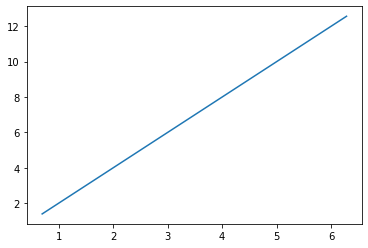

In [43]:
T = np.arange (0,10)
kk = 2*np.pi/T
x = []
for k in kk :
    x.append( 2*k )

plt.plot (kk[1:],x[1:])

<ipython-input-72-c6cd70d87eb1>:4: RuntimeWarning: divide by zero encountered in true_divide
  k_array = 2*np.pi/T_array


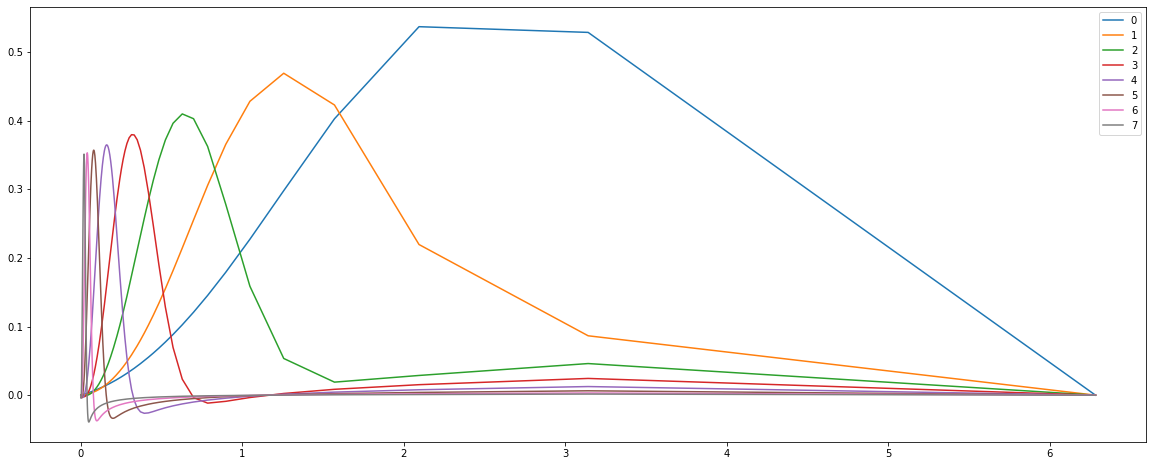

In [72]:
fig=plt.figure(figsize=[20,8])
T = 2**13
T_array = np.arange (0,T)
k_array = 2*np.pi/T_array
for j in range(8):
    sigma=0.8*2**j
    freq=(3.0*np.pi) /(4.0*2**j)
    morfft = []
    for i, k in enumerate (k_array[1:]):
        morfft.append (morletfft_tmp(sigma,freq,T,k))
    plt.plot(k_array[1:],morfft,label=str(j))
    plt.legend()
#     plt.xlim(0,.5)

In [148]:
def fourier_power_spectrum(img_r, img_len, bin_k):
    """
    Compute the Fourier power spectrum given a 2-dimensional real-space map.
    
    Parameters
    ----------
        img_r: arraylike
            2-dimensional real-space map 
            
        img_len: float
            image size 
            (units define output units of wavenumber and power spectrum)
            
        bin_k: int
            number of bins in Fourier space
            
    Returns
    -------
        k: np.ndarray
            wavenumber in units of inverse [img_len]
            
        pk: np.ndarray
            power spectrum in units of [img_len]**2
    """
    assert np.ndim(img_r) == 2, 'img_r is not 2D'
    img_pix = np.size(img_r, axis=0)  # pixel number per axis
    img_dim = np.ndim(img_r)  # image dimension

    # This first 'paragraph' is to create masks of indices corresponding to 
    # one Fourier bin each.
    freq = np.fft.fftfreq(n=img_pix, d=img_len/img_pix) * 2*np.pi
    rfreq = np.fft.rfftfreq(n=img_pix, d=img_len/img_pix) * 2*np.pi
    kx, ky = np.meshgrid(freq, rfreq, indexing='ij')
    k_abs = np.sqrt(kx**2. + ky**2.)
    # The following complicated line is actually only creating a 1D array 
    # spanning k-space logarithmically from minimum k_abs to maximum. To 
    # start slightly below the minimum and finish slightly above the maximum 
    # I use ceil and floor. To ceil and floor not to the next integer but to 
    # the next 15th digit, I multiply by 1e15 before flooring and divide by 
    # the same amount afterwards. Since the ceiled/floored value is actually 
    # the exponent used for the logspace, going to the next integer would be 
    # too much, which is why I do this ceil/floor to digit procedure.
    #k_log = np.logspace(np.floor(np.log10(np.min(k_abs[1:]))*1.e15)/1.e15, np.ceil(np.log10(np.max(k_abs[1:]))*1.e15)/1.e15, bin_k)
    k_lin = np.linspace(np.min (k_abs) , np.max (k_abs))
    img_k = np.fft.rfftn(np.fft.fftshift(img_r)) * (img_len/img_pix)**img_dim
    pk = np.empty(np.size(k_lin)-1)
    for i in range(np.size(k_lin)-1):
        mask = (k_abs >= k_lin[i]) & (k_abs < k_lin[i+1])
        #print (mask)
        pk[i] = np.mean(np.abs(img_k[mask])**2.) / img_len**img_dim

    k = k_lin[1:]

    return k, pk


In [149]:
def morlet2d (M , N, freq , sigma ):
    gab = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    #arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*x + 1.j * freq * y
    lowp = -(x**2+y**2)/(2*sigma*sigma)
    print (arg.shape)
    beta = np.sum (np.sum (arg , axis=0))
    gab += np.exp(arg) - beta * np.exp (lowp)

    norm_factor = (2 * np.pi * sigma * sigma)
    gab /= norm_factor
    return gab
    
    

In [150]:

j = 3
sigma=0.8*2**j
freq=(3.0*np.pi) /(4.0*2**j)


gab = morlet2d(1000 , 1000 , freq  ,sigma )

(1000, 1000)


In [151]:
morl2dfftk , morl2dfft  = fourier_power_spectrum(gab, 1000 , 1000)
print (morl2dfftk)

[0.09067108 0.18134216 0.27201324 0.36268432 0.4533554  0.54402648
 0.63469756 0.72536864 0.81603972 0.9067108  0.99738188 1.08805296
 1.17872404 1.26939513 1.36006621 1.45073729 1.54140837 1.63207945
 1.72275053 1.81342161 1.90409269 1.99476377 2.08543485 2.17610593
 2.26677701 2.35744809 2.44811917 2.53879025 2.62946133 2.72013241
 2.81080349 2.90147457 2.99214565 3.08281673 3.17348781 3.26415889
 3.35482997 3.44550105 3.53617213 3.62684321 3.7175143  3.80818538
 3.89885646 3.98952754 4.08019862 4.1708697  4.26154078 4.35221186
 4.44288294]


/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


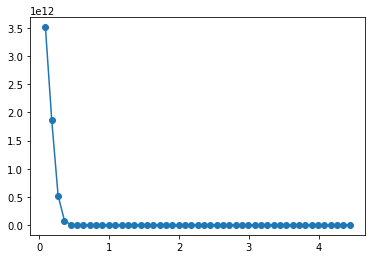

In [152]:
fig = plt.figure()
ax1 = plt.subplot(111)
ax1.plot(morl2dfftk, morl2dfft, '-o', ms=6)
#ax1.set_ylim(min(np.nanmin(fmap_pwl_1024_k[:20]**2/(2*pi)**2*fmap_pwl_1024_pk[:20])/10, 
             #np.nanmin(fmap_pwl_1024_k[:20]**2/(2*pi)**2*fmap_pwl_1024_pk[:20])/10))
#ax1.legend(bbox_to_anchor=(1, 1), handlelength=0, labelcolor='linecolor', title="Fourier power spectrum \nfrom the $\\bf{projection}$ to a flat map \nof the custom power spectrum")


In [32]:
def morletfft2d(sigma,freq,T):
    t=np.arange(0,T)
    gabor=np.exp(-(t**2)/(2*sigma**2))*np.exp(1.j*freq*t)
    #beta=np.exp(-((freq**2) *sigma**2)/2)
    #beta = np.sum (gabor)/ np.sum (np.exp(-(t**2)/(2*sigma**2)))
    lowp=np.exp(-(t**2)/(2*sigma**2))
    norm=2*np.pi*sigma**2
    beta = (np.sum (gabor))**2/ (np.sum (lowp))**2
    morlet=(gabor-beta*lowp)/norm
    
    #morfft=(np.fft.fft(morlet))**2
    
    return morfft

Morlet wavelet defined in the fourier space

In [164]:
def morletk(sigmat,freq,N):
    k=np.fft.fftfreq(N)
    #sigma=1./sigmat
    
    gabork=np.exp(-(k - freq)**2 * ( sigmat**2)/2)
    
    lowpassk=np.exp(-(k**2) * ( sigmat**2)/2)
    
    #beta=np.exp(-(freq**2)*( sigmat**2)/2)
    beta = np.sum (gabork)/np.sum (lowpassk)
    morlet_k = gabork - beta * lowpassk
    
#     m_real = np.fft.ifft(morlet_k)
#     norm_factor = 1. /(np.abs(m_real).sum())
    
#     morlet_k*=norm_factor
    
    return morlet_k, k

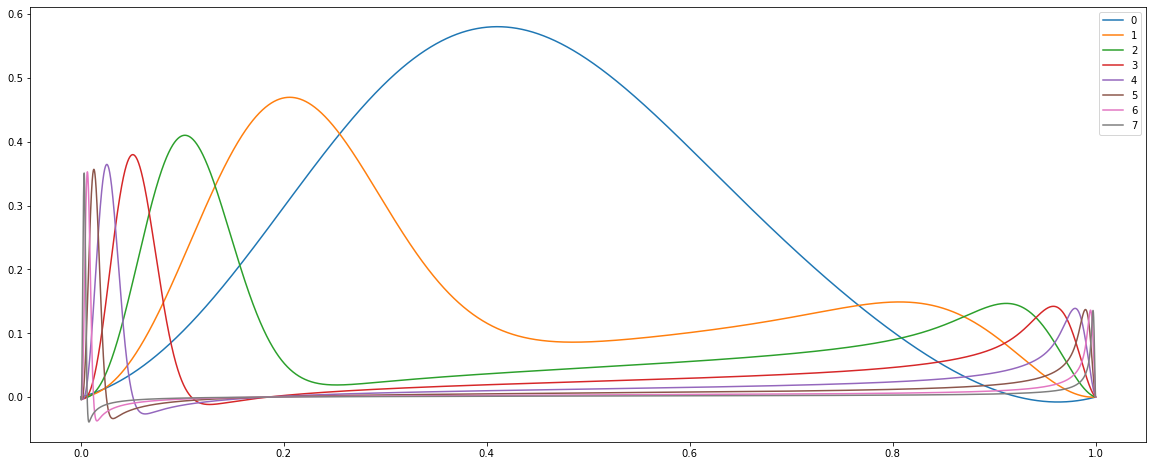

In [165]:
fig=plt.figure(figsize=[20,8])
for j in range(8):
    sigma=0.8*2**j
    freq=(3.0*np.pi) /(4.0*2**j)
    T = 2**15
    morfft=morletfft(sigma,freq,T)
    plt.plot(np.arange(T)/T,morfft.real,label=str(j))
    plt.legend()
#     plt.xlim(0,.5)

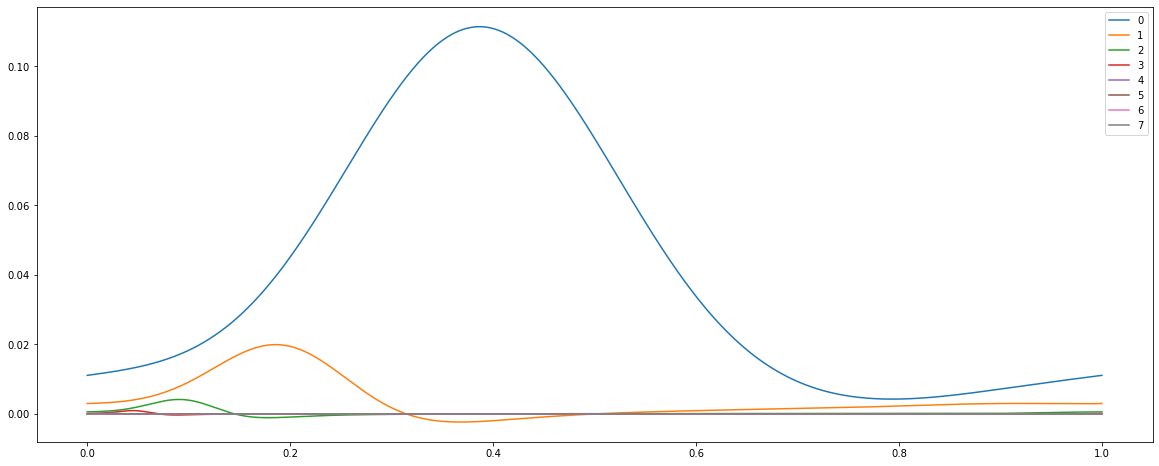

In [166]:
fig=plt.figure(figsize=[20,8])
for j in range(8):
    sigma=0.8*2**j
    freq=(3.0*np.pi) /(4.0*2**j)
    T = 2**15
    morfft=morletfft2d(sigma,freq,T)
    plt.plot(np.arange(T)/T,morfft.real,label=str(j))
    plt.legend()
#     plt.xlim(0,.5)

In [180]:
def morletk(sigmat,freq,N):
    #k=np.fft.fftfreq(N)
    N_arr = np.arange (1,N)
    k = 2*np.pi/N_arr
    #sigma=1./sigmat
    
    gabork=np.exp(-(k - freq)**2 * ( sigmat**2)/2)
    
    lowpassk=np.exp(-(k**2) * ( sigmat**2)/2)
    
    beta=np.exp(-(freq**2)*( sigmat**2)/2)
    #beta = np.sum (gabork)/np.sum (lowpassk)
    morlet_k = gabork - beta * lowpassk
    
#     m_real = np.fft.ifft(morlet_k)
#     norm_factor = 1. /(np.abs(m_real).sum())
    
#     morlet_k*=norm_factor
    
    return morlet_k, k

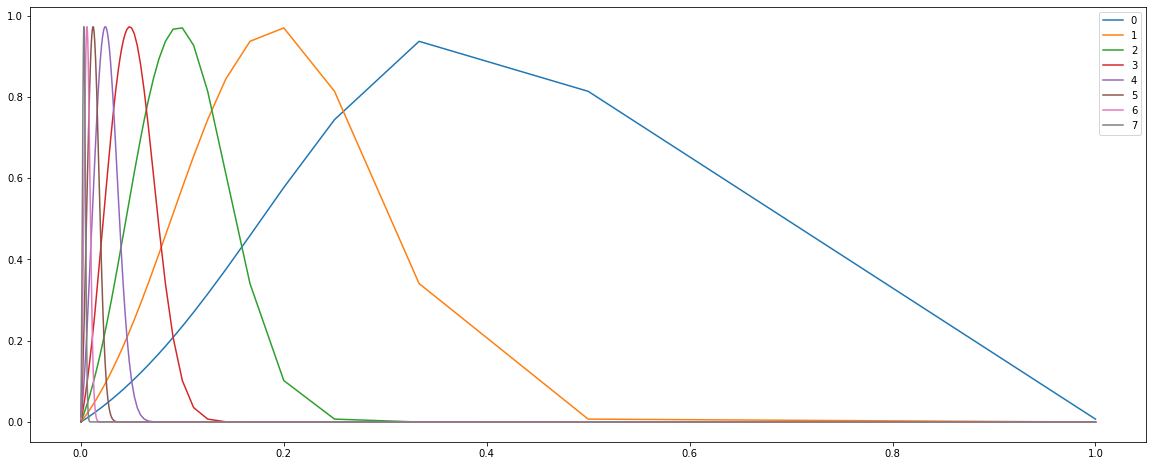

In [197]:
fig=plt.figure(figsize=[20,8])
for j in range(8):
    sigma=0.8*2**j
    freq=(3.0*np.pi) /(4.0*2**j)
    N= 2**14
    mork, k=morletk(sigma,freq,N)
    plt.plot(k/(2*np.pi),mork,label=str(j))
    plt.legend()
    #plt.xlim(0,2)

In [194]:
def gabor(freq,sigma,theta):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=2*np.pi*sigma*sigma
    return g

In [200]:
def morlet(f,sigma,theta,lmax):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=hp.beam2bl(wv,theta,lmax)[0]/hp.beam2bl(wvm,theta,lmax)[0]
    mor=wv-B*wvm
    return mor

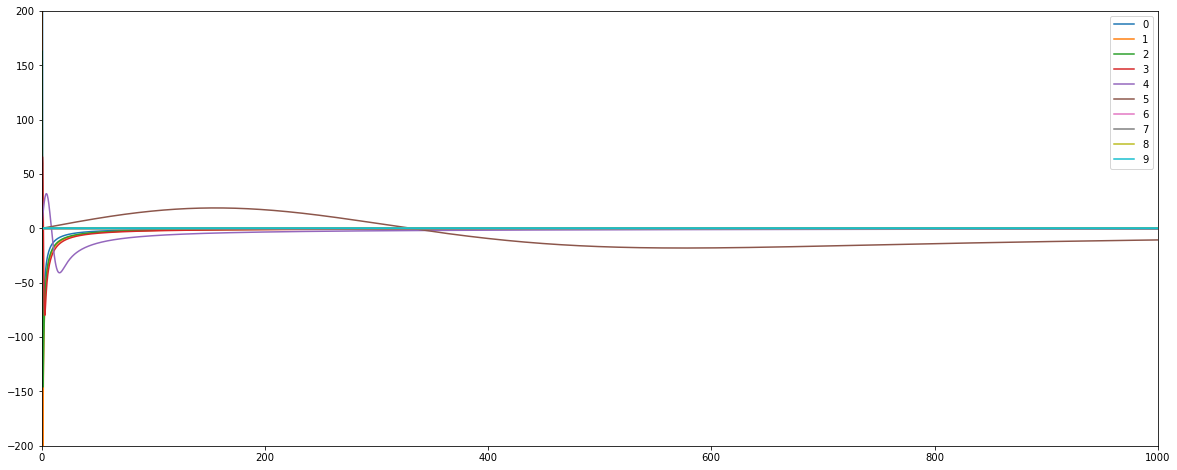

In [196]:
theta=np.linspace(0,np.pi,20000)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8**2**j)
    freq1=(3.0*np.pi) /(4.0*2**j)
    
    morf=morlet(freq1,sigma1,theta)
    mork=np.fft.fft(morf)
    k=np.fft.fftfreq(n=len(morf),d=theta[1]-theta[0])
#     plt.plot(theta,morf)
    plt.plot(k,mork.real,label=str(j))
    plt.legend()
    plt.xlim(0,1000)
    plt.ylim(-200,200)

In [216]:
lmax2=37000
ell2=np.arange(lmax2+1)

J=8
filters=[]
mor=[]
morl=[]
fl2beam=[]

theta=np.linspace(0,np.pi,20000)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)
    
    morf=morlet(freq1,sigma1,theta,lmax2)
    mor_l=hp.beam2bl(morf.real,theta,lmax=lmax2)
    
    mor.append(morf)
    morl.append(mor_l)
    fltr=np.zeros(lmax+1)
      
    mr=mor_l[mor_l>0]
    if len(mr) > len(fltr):
        
        fltr[:]=mr[:lmax+1]
    else:
        fltr=fltr+1e-9
        fltr[:len(mr)]=mr
    
    filters.append(fltr)
    
    beam=hp.bl2beam(fltr,theta)
    fl2beam.append(beam)
    
#     plt.plot(ell,fltr)
    
    
    
#     plt.plot(ell2,mor_l,label='j='+str(j))
#     plt.plot(ell,np.zeros(len(ell)),'k-')
#     plt.legend()

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


<Figure size 1440x576 with 0 Axes>

0.0009993424882289927


(0.0, 6000.0)

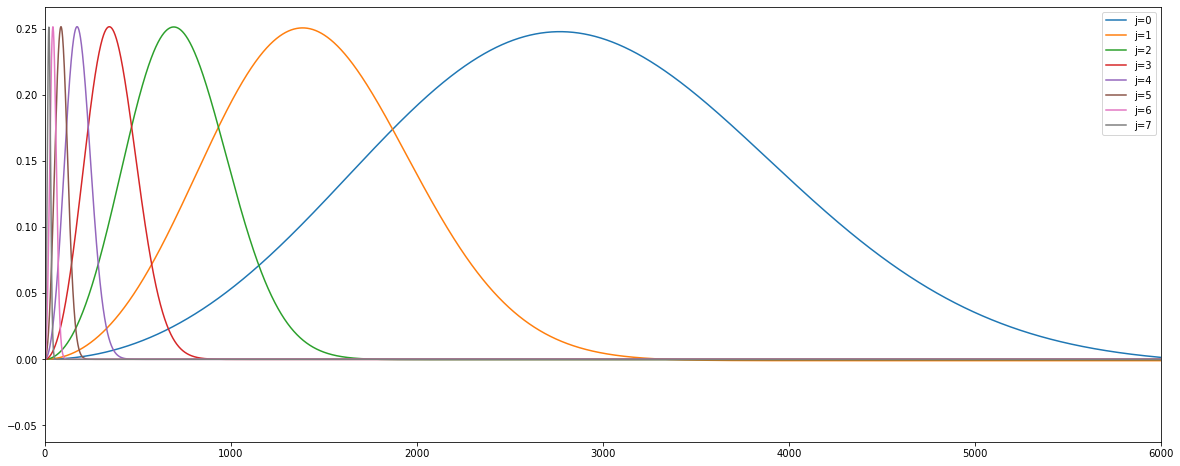

In [218]:
fig=plt.figure(figsize=[20,8])
for j in range(8):
    plt.plot(ell2,morl[j],label='j='+str(j))
    plt.legend()
    
print (resol)
plt.xlim(0,6000)

In [25]:
theta=np.linspace(0,np.pi,20000)
fig=plt.figure(figsize=[20,8])

phifilter=[]

for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)
    
    phi1=gabor(0,sigma1, theta)
    gab_l=hp.gauss_beam(2*np.sqrt(2*np.log(2))*sigma1,lmax=lmax)
    gab_lb=hp.beam2bl(phi1.real,theta,lmax=lmax)
    
    phifilter.append(gab_l)
    
#     plt.plot(ell,gab_l,label='j='+str(j),lw=4)
#     plt.plot(ell,gab_lb,label='j='+str(j))
#     plt.plot(ell,np.zeros(len(ell)),'k-')
#     plt.legend()

<Figure size 1440x576 with 0 Axes>

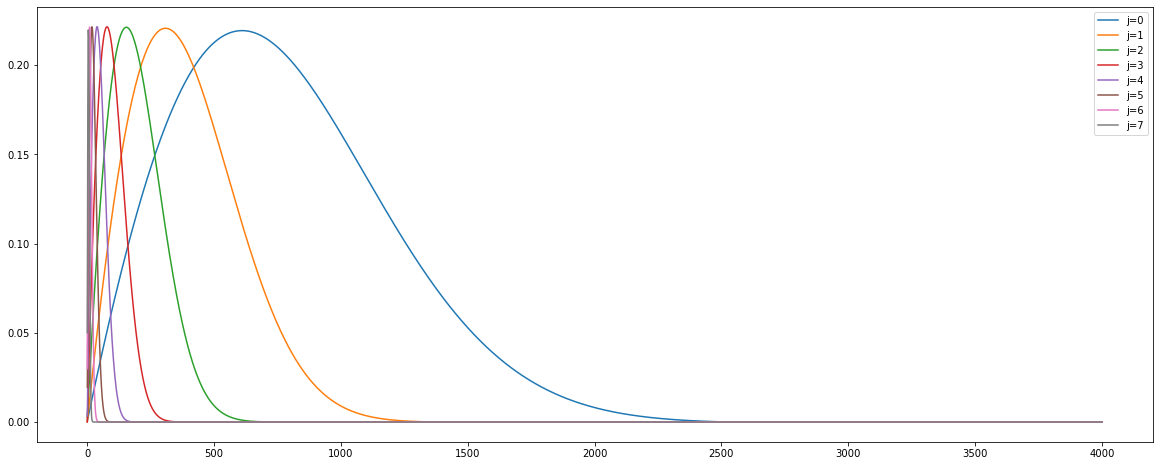

In [27]:
fig=plt.figure(figsize=[20,8])
for j in range(8):
    plt.plot(ell,filters[j],label='j='+str(j))
    plt.legend()

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


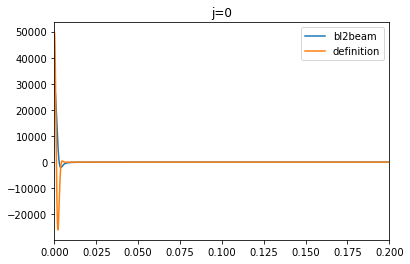

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


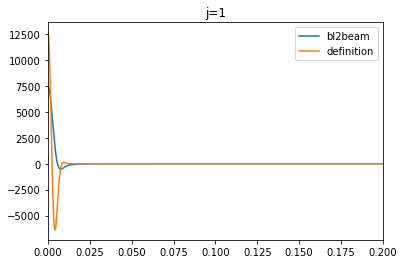

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


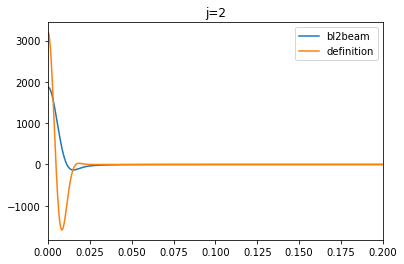

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


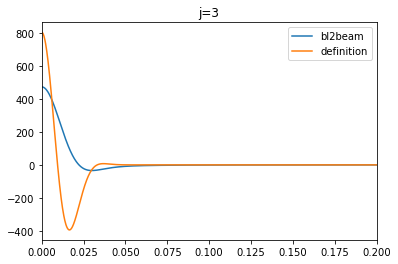

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


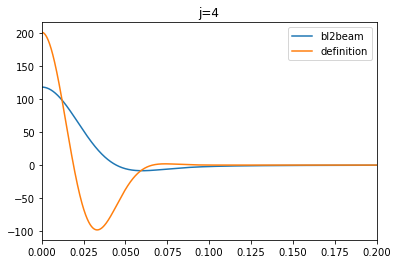

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


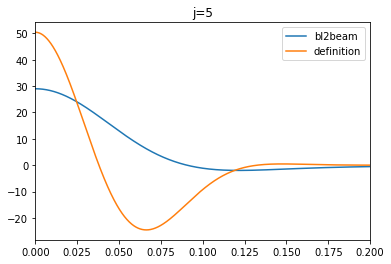

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


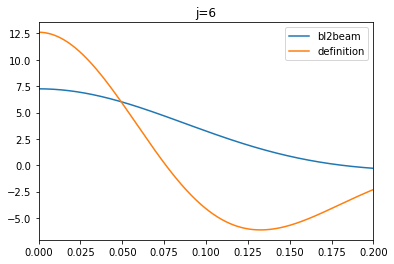

/home/shruti/anaconda3/envs/act_notebooks/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


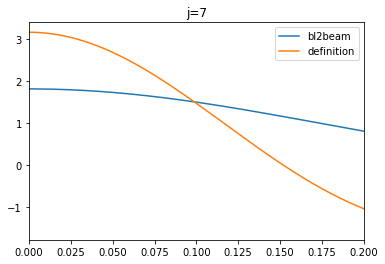

In [28]:
# fig=plt.figure(figsize=[20,8])
for j in range(8):
    plt.plot(theta,fl2beam[j],label='bl2beam')
    plt.title('j='+str(j))
    plt.plot(theta,mor[j],label='definition')
    plt.legend()
    plt.xlim(0,0.2)
    plt.show()

<font size="5">Scattering Transform</font>

Implementing the transform.

Wavelet description:

$\sigma = 0.8 \times 2^j$

$k = \frac{3\pi}{4 \times 2^j}$

Transform steps

Map = $I_0$

$\psi_1$ = set of filters corresponding to $j_1$

$\psi_2$ = set of filters corresponding to $j_2$

$\phi_1$ = Gaussian filter correspoding to $j_1$

$\phi_2$ = Gaussian filter correspoding to $j_2$

1. $I_1 = |I_0 \star \psi_1|$
2. $S_1 = \langle I_1 \star \phi_1 \rangle$
3. $I_2 = |I_1 \star \psi_2|$
4. $S_2 = \langle I_2 \star \phi_2 \rangle$


In [29]:
len(filters)

10

In [30]:
lmax

4000

In [32]:
hmap.mean()

-1.128530918169477e-05

In [33]:
hmap=hmap+10
hmap.mean()

9.99998871469081

In [34]:
%%time

theta=np.linspace(0,np.pi,5000)

S1=np.zeros((8))

i1=[]

for j1 in range(8):
    
    sigma1 = (0.8*resol*2**j1) # multiplied by resolution in radians
    freq1=(3.0*np.pi) /(4.0*resol*2**j1) #divided by resolution in radians
    
    #filter 1
    f1=filters[j1] 
    
    #convolving the map with filter 1
    mapalm=hp.map2alm(hmap,lmax=lmax,use_pixel_weights=True)
    nalm=hp.almxfl(mapalm,f1)
    I1=hp.alm2map(nalm,nside,lmax)
    
    #modulus
    I1=np.abs(I1)
    
    i1.append(I1)
    
    #Gaussian filter for S1
    phif=phifilter[j]
    
    #Convolving with gaussian filter to get S1
    I1alm=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
    nI1alm=hp.almxfl(I1alm,phif)
    S1map=hp.alm2map(nI1alm,nside,lmax)
    
    #Averaging the entire map
    S1[j1]=np.mean(S1map)
    print(j1)

0
1
2
3
4
5
6
7
CPU times: user 6min 14s, sys: 2.7 s, total: 6min 17s
Wall time: 1min 43s


In [36]:
np.save("S1_512_plus10.npy",S1)

In [39]:
S1m=np.load("S1_512.npy")

Text(0.5, 1.0, 'S1 coefficients')

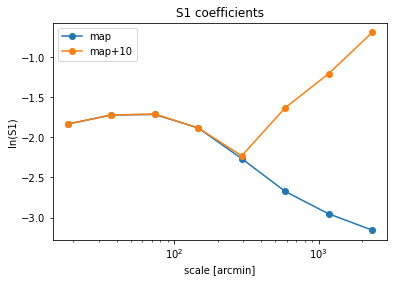

In [41]:
Jf=np.arange(8)
scale=2**Jf*((2*resarc)/0.75)

plt.plot(scale,np.log(S1m),marker='o',label='map')
plt.plot(scale,np.log(S1),marker='o',label='map+10')
plt.legend()
plt.xscale('log')
plt.xlabel("scale [arcmin]")
plt.ylabel("ln(S1)")
plt.title("S1 coefficients")

In [55]:
print(len(i1))
print(i1[0].shape)

8
(50331648,)


In [ ]:
%%time

S2=np.zeros((8,8))

for j1 in range(8):
    I1=i1[j1]
    
    for j2 in range (8):
                
        sigma2 = (0.8*resol*2**j2)
        freq2=(3.0*np.pi) /(4.0*resol*2**j2)
        
        #filter 2        
        f2=filters[j2]
        
        #Convolving I1 with filter 2
        mapalm2=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
        nalm2=hp.almxfl(mapalm2,f2)
        I2=hp.alm2map(nalm2,nside,lmax)
        
        #modulus
        I2=np.abs(I2)
        
        #Gaussian filter to get S2
        phif2=phifilter[j]
    
        #Convolving with gaussian filter to get S2
        I2alm=hp.map2alm(I2,lmax=lmax,use_pixel_weights=True)
        nI2alm=hp.almxfl(I2alm,phif2)
        S2map=hp.alm2map(nI2alm,nside,lmax)     
                       
        #averaging the entire map
        S2[j1][j2]=np.mean(S2map)
    print(j1)

0
1
2
3
4
5
6


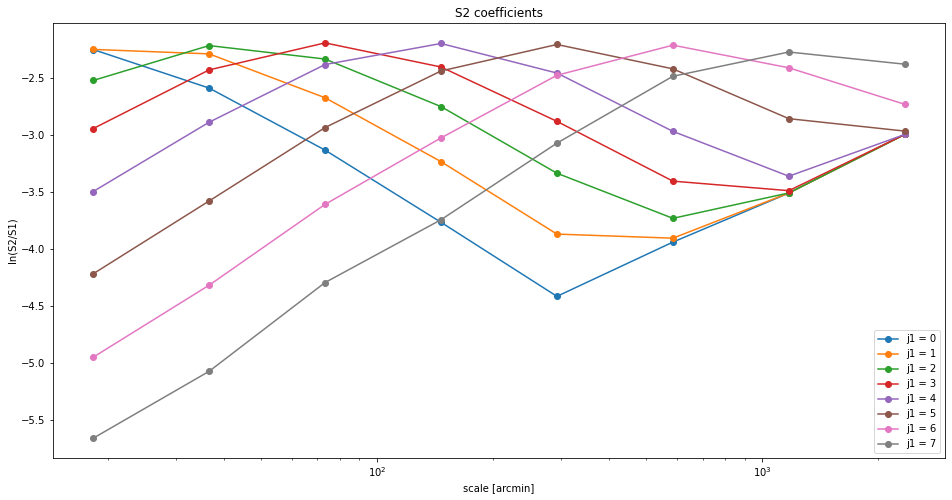

In [26]:
fig=plt.figure(figsize=[16,8])
for j in range (8):
    plt.plot(scale,np.log(S2[j]/S1[j]),marker='o',label="j1 = "+str(j))
    plt.xscale('log')
    plt.xlabel("scale [arcmin]")
    plt.legend(loc='best')
    plt.ylabel("ln(S2/S1)")
    plt.title("S2 coefficients")

Text(0, 0.5, 'ln(s2/s1)')

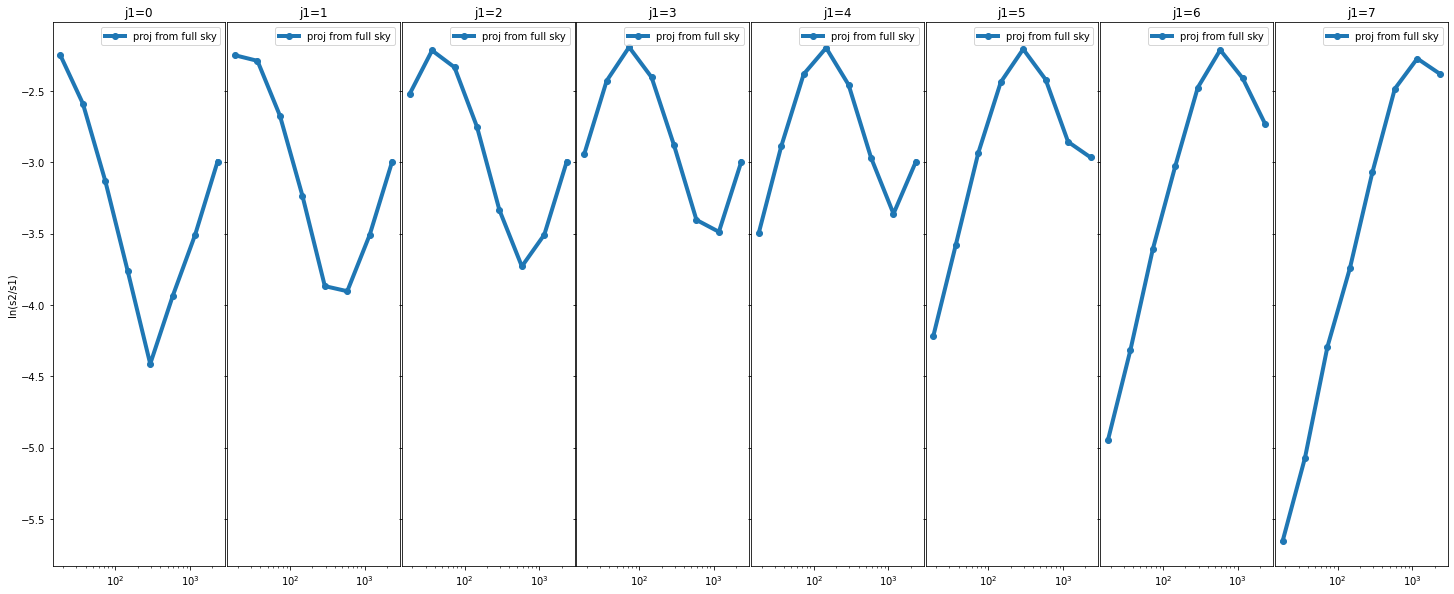

In [27]:
fig, ax = plt.subplots(1, 8,sharey=True,squeeze=True,figsize=(25,10))

ax[0].plot(scale,np.log(S2[0,:]/S1[0]),'o-',label='proj from full sky',lw=4)
# ax[0].plot(scale,np.log(s2[0,:]/cs1[0]),'o-',label='flat sky')
ax[0].set_title('j1=0')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].plot(scale,np.log(S2[1,:]/S1[1]),'o-',label='proj from full sky',lw=4)
# ax[1].plot(scale,np.log(cs2[1,:]/cs1[1]),'o-',label='flat sky')
ax[1].set_title('j1=1')
ax[1].set_xscale('log')
ax[1].legend()
ax[2].plot(scale,np.log(S2[2,:]/S1[2]),'o-',label='proj from full sky',lw=4)
# ax[2].plot(scale,np.log(cs2[2,:]/cs1[2]),'o-',label='flat sky')
ax[2].set_title('j1=2')
ax[2].set_xscale('log')
ax[2].legend()
ax[3].plot(scale,np.log(S2[3,:]/S1[3]),'o-',label='proj from full sky',lw=4)
# ax[3].plot(scale,np.log(cs2[3,:]/cs1[3]),'o-',label='flat sky')
ax[3].set_title('j1=3')
ax[3].set_xscale('log')
ax[3].legend()
ax[4].plot(scale,np.log(S2[4,:]/S1[4]),'o-',label='proj from full sky',lw=4)
# ax[4].plot(scale,np.log(cs2[4,:]/cs1[4]),'o-',label='flat sky')
ax[4].set_title('j1=4')
ax[4].set_xscale('log')
ax[4].legend()
ax[5].plot(scale,np.log(S2[5,:]/S1[5]),'o-',label='proj from full sky',lw=4)
# ax[5].plot(scale,np.log(cs2[5,:]/cs1[5]),'o-',label='flat sky')
ax[5].set_title('j1=5')
ax[5].set_xscale('log')
ax[5].legend()
ax[6].plot(scale,np.log(S2[6,:]/S1[6]),'o-',label='proj from full sky',lw=4)
# ax[6].plot(scale,np.log(cs2[6,:]/cs1[6]),'o-',label='flat sky')
ax[6].set_title('j1=6')
ax[6].set_xscale('log')
ax[6].legend()
ax[7].plot(scale,np.log(S2[7,:]/S1[7]),'o-',label='proj from full sky',lw=4)
# ax[7].plot(scale,np.log(cs2[7,:]/cs1[7]),'o-',label='flat sky')
ax[7].set_title('j1=7')
ax[7].set_xscale('log')
ax[7].legend()
plt.subplots_adjust(wspace=0.01,hspace=0.35)
ax[0].set_ylabel("ln(s2/s1)")

In [28]:
S1


array([0.15967086, 0.17874863, 0.17994386, 0.15203935, 0.10376826,
       0.06890647, 0.0521329 , 0.04254998])

In [29]:
S2

array([[0.01680251, 0.01198892, 0.00696253, 0.0036993 , 0.001934  ,
        0.00311054, 0.00477972, 0.00798728],
       [0.01883149, 0.01810793, 0.01233124, 0.00704599, 0.00373488,
        0.00360367, 0.00535081, 0.00894161],
       [0.01444161, 0.01960398, 0.01742142, 0.01148665, 0.00640811,
        0.00431657, 0.0053918 , 0.0090014 ],
       [0.00800392, 0.01338584, 0.016958  , 0.01372885, 0.00852852,
        0.00505171, 0.00464728, 0.00760552],
       [0.00314758, 0.00577608, 0.00957533, 0.01151317, 0.00888649,
        0.00533287, 0.00359946, 0.00519084],
       [0.00101665, 0.00192383, 0.00366098, 0.00600876, 0.0075785 ,
        0.00612256, 0.00395727, 0.00354921],
       [0.0003704 , 0.00069606, 0.00141326, 0.00252982, 0.0043787 ,
        0.00569969, 0.00467518, 0.00339472],
       [0.00014871, 0.00026723, 0.0005816 , 0.00100817, 0.00197225,
        0.00354302, 0.00438083, 0.0039379 ]])

In [30]:
np.save("S1_512.npy",S1)

In [31]:
np.save("S2_512.npy",S2)

In [7]:
s1f=np.load("flat_cirsym_res=2_S1.npy")
s2f=np.load("flat_cirsym_res=2_S2.npy")

s1a=np.load("S1_512.npy")
s2a=np.load("S2_512.npy")

s1b=np.load("S1_1024.npy")
s2b=np.load("S2_1024.npy")

s1c=np.load("S1_2048.npy")
s2c=np.load("S2_2048.npy")

In [8]:
resf=2
resa=hp.nside2resol(512,arcmin=True)
resb=hp.nside2resol(1024,arcmin=True)
resc=hp.nside2resol(2048,arcmin=True)
print(resf)
print(resa)
print(resb)
print(resc)

2
6.870972823634812
3.435486411817406
1.717743205908703


Text(0.5, 1.0, 'S1 coefficients')

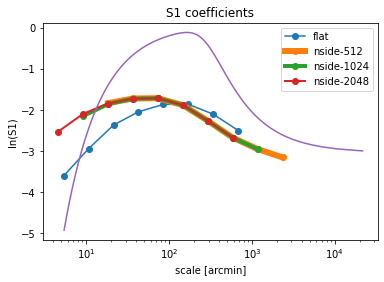

In [9]:
Jarr=np.arange(8)
scf=2**Jarr*((2*resf)/0.75)
sca=2**Jarr*((2*resa)/0.75)
scb=2**Jarr*((2*resb)/0.75)
scc=2**Jarr*((2*resc)/0.75)

plt.plot(scf,np.log(s1f),marker='o',label='flat')
plt.plot(sca,np.log(s1a),marker='o',label='nside-512',lw=6)
plt.plot(scb,np.log(s1b),marker='o',label='nside-1024',lw=4)
plt.plot(scc,np.log(s1c),marker='o',label='nside-2048',lw=2)
plt.plot(ellsc,np.log(fdl))
plt.xscale('log')
plt.xlabel("scale [arcmin]")
plt.ylabel("ln(S1)")
plt.legend()
plt.title("S1 coefficients")

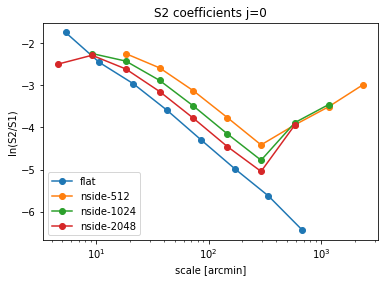

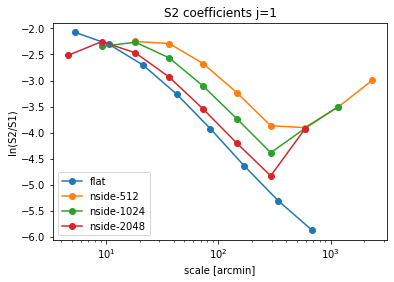

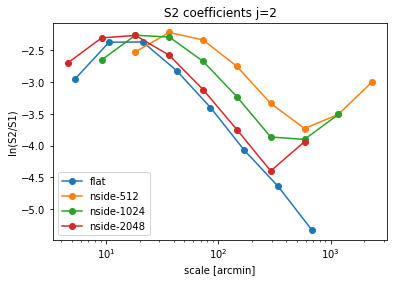

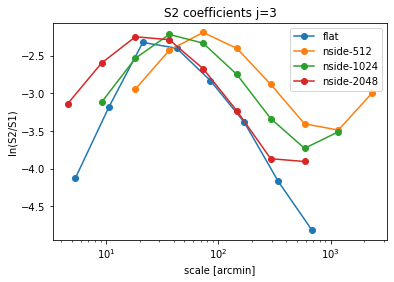

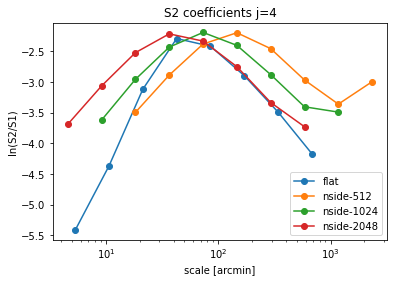

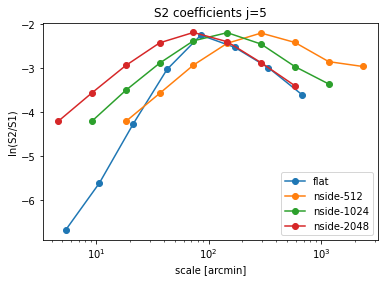

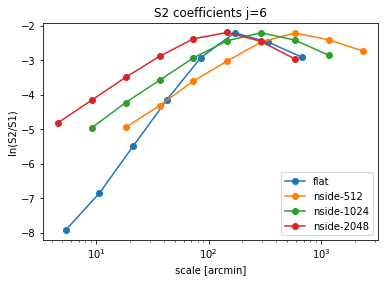

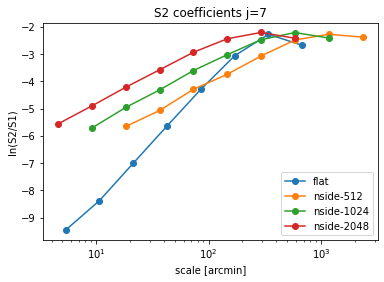

In [19]:
for j in range (8):
    plt.plot(scf,np.log(s2f[j]/s1f[j]),marker='o',label='flat')
    plt.plot(sca,np.log(s2a[j]/s1a[j]),marker='o',label='nside-512')
    plt.plot(scb,np.log(s2b[j]/s1b[j]),marker='o',label='nside-1024')
    plt.plot(scc,np.log(s2c[j]/s1c[j]),marker='o',label='nside-2048')
    plt.xscale('log')
    plt.xlabel("scale [arcmin]")
    plt.legend(loc='best')
    plt.ylabel("ln(S2/S1)")
    plt.title("S2 coefficients j="+str(j))
    plt.savefig("s2comp"+str(j)+".png")
    plt.show() 